In [1]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import torch
import datasets
import numpy as np
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps")

In [3]:

# Load the fine-tuned model
model_path = 'llama-finetuned/'
finetuned_model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)

# Load the tokenizer
finetuned_tokenizer = AutoTokenizer.from_pretrained(model_path)
finetuned_tokenizer.pad_token = finetuned_tokenizer.eos_token
finetuned_model.config.pad_token_id = finetuned_tokenizer.pad_token_id

In [4]:
# read in the llm testing data
data = datasets.load_dataset("json", data_files="llm_data/test.json")

In [5]:
example_input = data['train'][100000]['input']
tokenized_input = finetuned_tokenizer(
    example_input,
    padding=True,
    truncation=True,
    max_length=80,
    return_tensors="pt",
).to(device)

In [6]:
example_input

'Loan amount: 24000.0, Interest rate: 10.75, Annual income: 124000.0, Debt to income ratio: 6.79, Purpose: credit_card, FICO range high: 694.0, Issue date: 2016-02-01.'

In [133]:
with torch.no_grad():
    outputs = finetuned_model(**tokenized_input)
    logits = outputs.logits
    predicted_probabilities = torch.nn.functional.softmax(logits, dim=-1)

print(f"Predicted class: {predicted_probabilities}")

Predicted class: tensor([[0.7542, 0.2458]], device='mps:0')


In [7]:
lgb_data = pd.read_csv("lgb_data/lgb_x_train_20160101.csv")

In [33]:
FICO_scores = lgb_data.fico_range_high.unique()
FICO_scores.sort()
print(f"FICO scores: {FICO_scores}")

FICO scores: [629. 634. 664. 669. 674. 679. 684. 689. 694. 699. 704. 709. 714. 719.
 724. 729. 734. 739. 744. 749. 754. 759. 764. 769. 774. 779. 784. 789.
 794. 799. 804. 809. 814. 819. 824. 829. 834. 839. 844. 850.]


### First experiment: vary FICO

In [34]:
# generate inputs for the model, that are based on the example input, but with different FICO scores
def generate_inputs(example_input, fico_scores):
    inputs = []
    for score in fico_scores:
        input_text = example_input.replace("FICO range high: 694.0", f"FICO range high: {score}")
        inputs.append(input_text)
    return inputs

In [35]:
generated_inputs = generate_inputs(example_input, FICO_scores)
# Tokenize the generated inputs
tokenized_inputs = finetuned_tokenizer(
    generated_inputs,
    padding=True,
    truncation=True,
    max_length=80,
    return_tensors="pt",
).to(device)
# Get the model predictions for the generated inputs
with torch.no_grad():
    outputs = finetuned_model(**tokenized_inputs)
    logits = outputs.logits
    predicted_probabilities = torch.nn.functional.softmax(logits, dim=-1)
# Convert the predicted probabilities to numpy arrays
predicted_probabilities = predicted_probabilities.cpu().numpy()

In [163]:
unseen_fico_scores = np.random.randint(630, 850, size=100)
# filter out the FICO scores that are already in the dataset
unseen_fico_scores = [score for score in unseen_fico_scores if score not in FICO_scores]

generated_inputs_unseen = generate_inputs(example_input, unseen_fico_scores)
# Tokenize the generated inputs
tokenized_inputs = finetuned_tokenizer(
    generated_inputs_unseen,
    padding=True,
    truncation=True,
    max_length=80,
    return_tensors="pt",
).to(device)
# Get the model predictions for the generated inputs
with torch.no_grad():
    outputs = finetuned_model(**tokenized_inputs)
    logits = outputs.logits
    predicted_probabilities_unseen = torch.nn.functional.softmax(logits, dim=-1)
# Convert the predicted probabilities to numpy arrays
predicted_probabilities_unseen = predicted_probabilities_unseen.cpu().numpy()

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

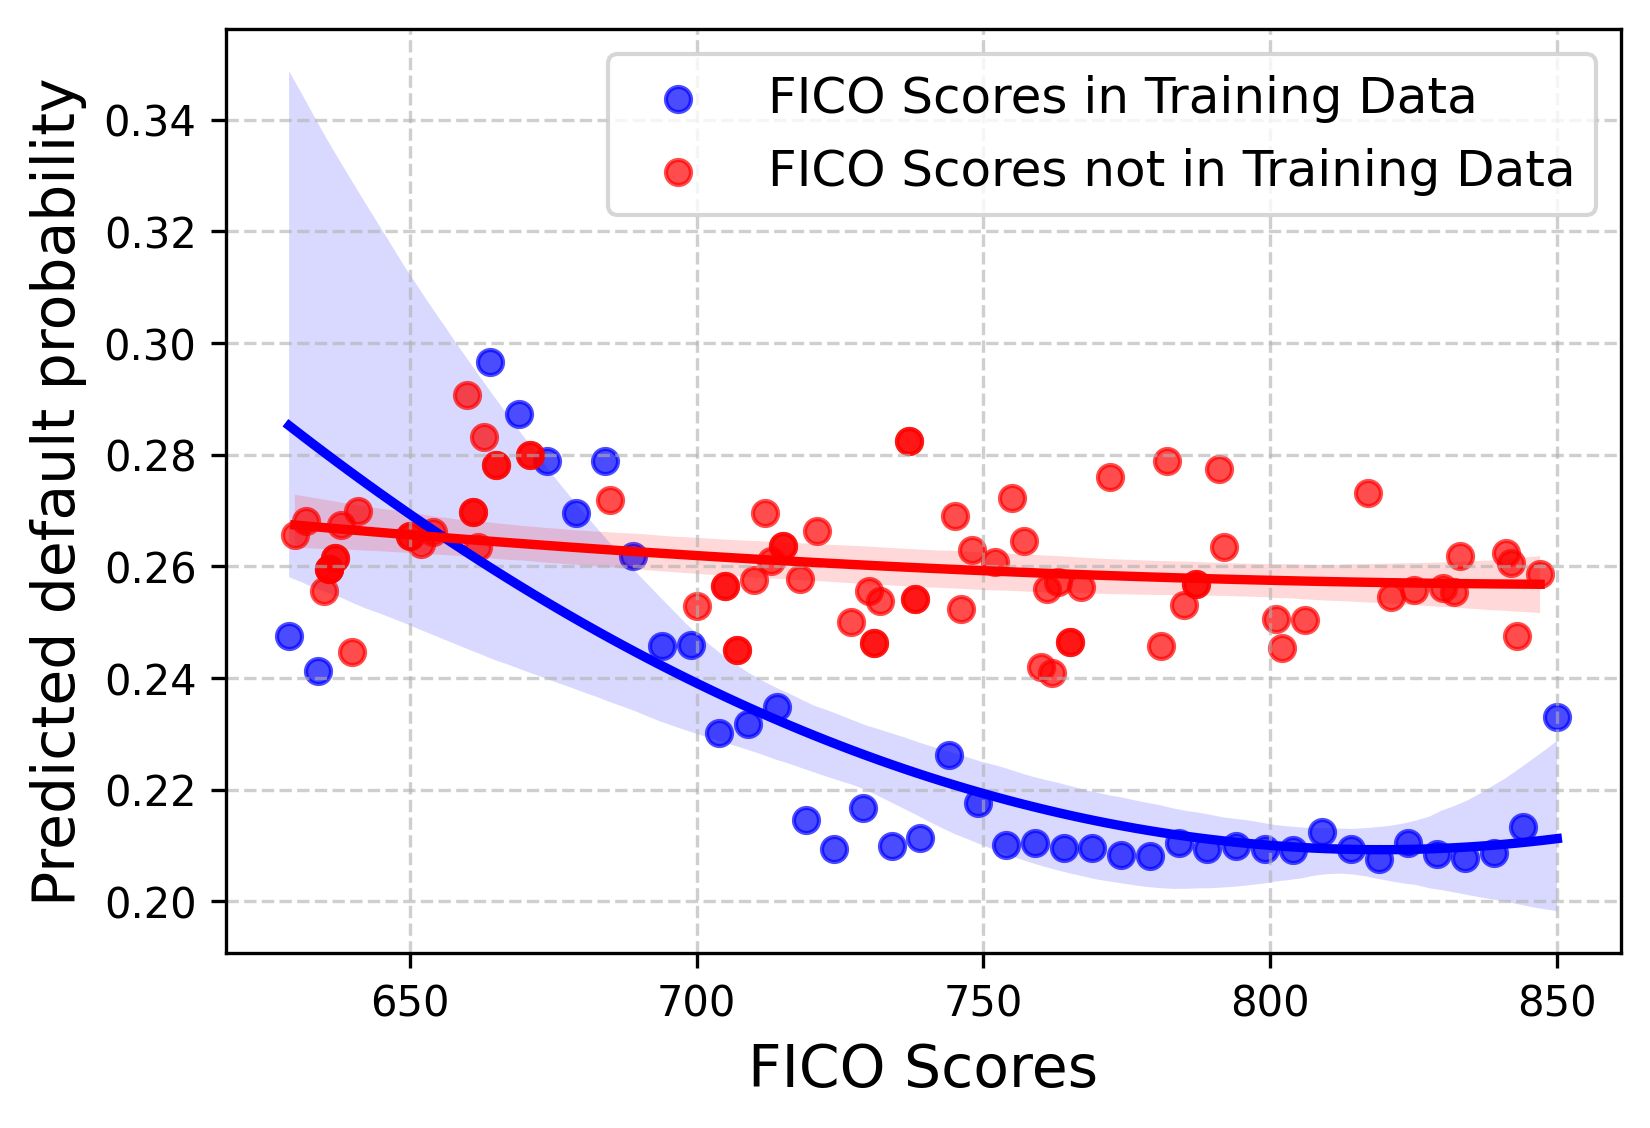

In [ ]:


plt.figure(figsize=(6, 4), dpi = 300)
sns.regplot(x=FICO_scores, y=predicted_probabilities[:, 1], scatter_kws={'color': 'blue', 'alpha': 0.7}, order=2, line_kws={'color': 'blue'}, label="FICO Scores in Training Data")
sns.regplot(x=unseen_fico_scores, y=predicted_probabilities_unseen[:, 1], scatter_kws={'color': 'red', 'alpha': 0.7}, order=2, line_kws={'color': 'red'}, label="FICO Scores not in Training Data")
# plt.title("Predicted Probabilities vs. FICO Scores", fontsize=16)
plt.xlabel("FICO Scores", fontsize=14)
plt.ylabel("Predicted default probability", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.savefig("plots/fico_scores_vs_predicted_probabilities.png", bbox_inches='tight', dpi=300)
plt.show()

### second experiment: vary interest rate

In [13]:
seen_interest_rates = lgb_data.int_rate.unique()
# subsample the interest rates to 100
seen_interest_rates_sampled = np.random.choice(seen_interest_rates, size=100, replace=False)

In [14]:
unseen_interest_rates = np.random.uniform(seen_interest_rates.min(), seen_interest_rates.max(), size=100)
# filter out the interest rates that are already in the dataset
unseen_interest_rates = [rate for rate in unseen_interest_rates if rate not in seen_interest_rates]

In [24]:
# generate inputs for the model, that are based on the example input, but with different FICO scores
def generate_inputs_interest_rate(example_input, int_rates):
    inputs = []
    for int_rate in int_rates:
        input_text = example_input.replace("Interest rate: 10.75", f"Interest rate: {int_rate}")
        inputs.append(input_text)
    return inputs

In [25]:
generated_inputs_intrate = generate_inputs_interest_rate(example_input, seen_interest_rates_sampled)
# Tokenize the generated inputs
tokenized_inputs = finetuned_tokenizer(
    generated_inputs_intrate,
    padding=True,
    truncation=True,
    max_length=80,
    return_tensors="pt",
).to(device)
# Get the model predictions for the generated inputs
with torch.no_grad():
    outputs = finetuned_model(**tokenized_inputs)
    logits = outputs.logits
    predicted_probabilities = torch.nn.functional.softmax(logits, dim=-1)
# Convert the predicted probabilities to numpy arrays
predicted_probabilities = predicted_probabilities.cpu().numpy()

In [26]:
generated_inputs_intrateunseen = generate_inputs_interest_rate(example_input, unseen_interest_rates)
# Tokenize the generated inputs
tokenized_inputs = finetuned_tokenizer(
    generated_inputs_intrateunseen,
    padding=True,
    truncation=True,
    max_length=80,
    return_tensors="pt",
).to(device)
# Get the model predictions for the generated inputs
with torch.no_grad():
    outputs = finetuned_model(**tokenized_inputs)
    logits = outputs.logits
    predicted_probabilities_unseen = torch.nn.functional.softmax(logits, dim=-1)
# Convert the predicted probabilities to numpy arrays
predicted_probabilities_unseen = predicted_probabilities_unseen.cpu().numpy()

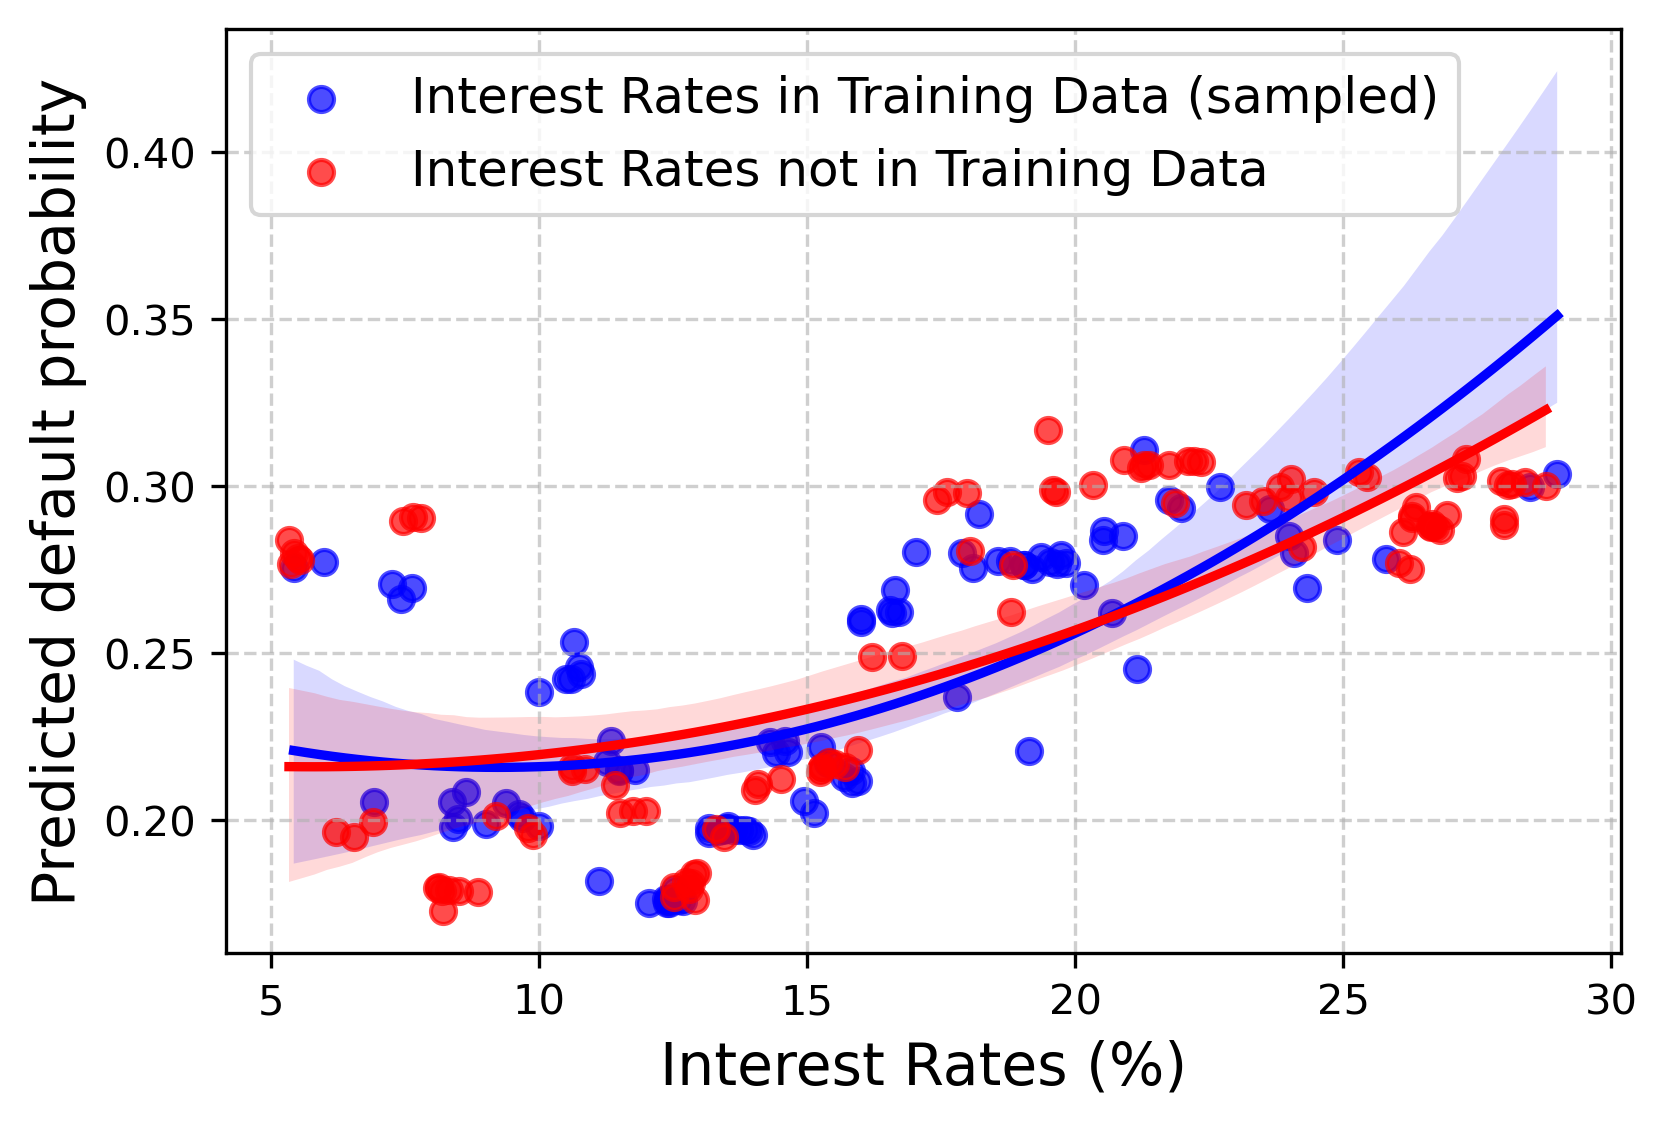

In [32]:
# then do a similar plot as above
plt.figure(figsize=(6, 4), dpi = 300)
sns.regplot(x=seen_interest_rates_sampled, y=predicted_probabilities[:, 1], scatter_kws={'color': 'blue', 'alpha': 0.7}, order=2, line_kws={'color': 'blue'}, label="Interest Rates in Training Data (sampled)")
sns.regplot(x=unseen_interest_rates, y=predicted_probabilities_unseen[:, 1], scatter_kws={'color': 'red', 'alpha': 0.7}, order=2, line_kws={'color': 'red'}, label="Interest Rates not in Training Data")
# plt.title("Predicted Probabilities vs. Interest Rates", fontsize=16)
plt.xlabel("Interest Rates (%)", fontsize=14)
plt.ylabel("Predicted default probability", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.savefig("plots/interest_rates_vs_predicted_probabilities.png", bbox_inches='tight', dpi=300)
plt.show()